In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import cv2
from scipy import ndimage

folder_path = "20230530_segm_black_mouse_mnSLA_red_and_black_back"

seed_value = 52
torch.manual_seed(seed_value)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
def LoG_filter(image, sigma, size=None):
    if size is None:
        size = int(6 * sigma + 1) if sigma >= 1 else 7

    if size % 2 == 0:
        size += 1

    x, y = np.meshgrid(np.arange(-size//2+1, size//2+1), np.arange(- size // 2 + 1, size // 2 + 1))
    kernel = -(1/(np.pi * sigma**4)) * (1 - ((x**2 + y**2) / (2 * sigma**2))) * np.exp(- (x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / np.sum(np.abs(kernel))

    result = ndimage.convolve(image, kernel)
    return result

In [29]:
def augmentation():
    count_image = 200
    path_images = "20230530_segm_black_mouse_mnSLA_red_and_black_back/images"
    path_masks = "20230530_segm_black_mouse_mnSLA_red_and_black_back/masks"

    image_files = os.listdir(path_images)
    selected_files_for_vertical = random.sample(image_files, count_image)

    for filename in selected_files_for_vertical:
        image_path = os.path.join(path_images, filename)
        image = Image.open(image_path)
        rotated_image = image.transpose(Image.FLIP_LEFT_RIGHT)
        output_path = os.path.join(path_images, f'revert_vertical_{filename}')
        rotated_image.save(output_path)
        image.close()

        mask_path = os.path.join(path_masks, filename)
        mask = Image.open(mask_path)
        rotated_mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        output_path = os.path.join(path_masks, f'revert_vertical_{filename}')
        rotated_mask.save(output_path)
        mask.close()

    # selected_files_for_horizontal = []
    count_image = 1
    selected_files_for_horizontal = random.sample(image_files, count_image)

    for filename in selected_files_for_horizontal:
        image_path = os.path.join(path_images, filename)
        image = Image.open(image_path)
        rotated_image = image.transpose(Image.FLIP_TOP_BOTTOM)
        output_path = os.path.join(path_images, f'revert_horizontal_{filename}')
        rotated_image.save(output_path)
        image.close()

        mask_path = os.path.join(path_masks, filename)
        mask = Image.open(mask_path)
        rotated_mask = mask.transpose(Image.FLIP_TOP_BOTTOM)
        output_path = os.path.join(path_masks, f'revert_horizontal_{filename}')
        rotated_mask.save(output_path)
        mask.close()

    return selected_files_for_vertical, selected_files_for_horizontal


def delete_generated_images(data_vert, data_hor):
    path_images = "20230530_segm_black_mouse_mnSLA_red_and_black_back/images"
    path_masks = "20230530_segm_black_mouse_mnSLA_red_and_black_back/masks"

    for filename in data_vert:
        output_image_path = os.path.join(path_images, f'revert_vertical_{filename}')
        os.remove(output_image_path)

        output_mask_path = os.path.join(path_masks, f'revert_vertical_{filename}')
        os.remove(output_mask_path)

    for filename in data_hor:
        output_image_path = os.path.join(path_images, f'revert_horizontal_{filename}')
        os.remove(output_image_path)

        output_mask_path = os.path.join(path_masks, f'revert_horizontal_{filename}')
        os.remove(output_mask_path)

In [30]:
def make_csv_files(folder_path, folder):
    images_folder = folder_path + "/" + folder + "images"
    masks_folder = folder_path + "/" + folder + "masks"

    images_files = os.listdir(images_folder)
    masks_files = os.listdir(masks_folder)

    image_paths = [os.path.join(folder + "images", file) for file in images_files]
    mask_paths = [os.path.join(folder + "masks", file) for file in masks_files]

    data = {'orig_image': image_paths, 'mask_image': mask_paths}
    df = pd.DataFrame(data)

    csv_file_path = "train_data.csv" if folder == "" else "test_data.csv"

    df.to_csv(csv_file_path, index=False)

In [31]:
data_vertical, data_horizontal = augmentation()
make_csv_files(folder_path, "")
make_csv_files(folder_path, "test_")

In [3]:
train_df = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [4]:
def draw(orig_image, orig_masks, mask_image, intersec_mask):
    fig, axes = plt.subplots(1, 4)

    orig_image = orig_image.transpose(1, 2, 0)
    orig_image = (np.array(orig_image) - np.min(orig_image)) / (np.max(orig_image) - np.min(orig_image))
    axes[0].imshow(orig_image)
    axes[0].set_title('Original Image')

    axes[1].imshow(orig_masks)
    axes[1].set_title('Original Mask')
    
    axes[2].imshow(mask_image)
    axes[2].set_title('Predicted Mask')

    axes[3].imshow(intersec_mask)
    axes[3].set_title('Difference Mask')

    plt.tight_layout()
    plt.show()

In [5]:
def calculate_iou(predictions, targets):
    total_sum = 0.0
    for prediction, target in zip(predictions, targets):
        intersection = np.logical_and(prediction, target).sum().item()
        union = np.logical_or(prediction, target).sum().item()
        
        total_sum += intersection / union if union > 0 else 0.0

    return total_sum / len(predictions)

In [6]:
def compute_ap(predictions, targets):
    total_sum = 0.0
    thresholds = np.linspace(0, 1, 100)
    precisions = []
    recalls = []
    eps = 1e-7
    for prediction, target in zip(predictions, targets):
        for threshold in thresholds:
            output_thresh = (prediction>= threshold).astype(float)
            tp = np.sum(output_thresh * target)
            fp = np.sum(output_thresh * (1 - target))
            fn = np.sum((1 - output_thresh) * target)
            precisions.append((tp + eps) / (tp + fp + eps))
            recalls.append((tp + eps) / (tp + fn + eps))

        total_sum += np.trapz(precisions, recalls)
    return total_sum / len(predictions)

### Preprocessing (подготовка данных)

In [7]:
class ImagesDataset(Dataset):
    def __init__(self, folder, data, transform_image, transform_mask):
      self.folder = folder
      self.data = data.copy()
      self.orig_image_paths = [os.path.join(folder, filename) for filename in data['orig_image'].copy()]
      self.mask_image_paths = [os.path.join(folder, filename) for filename in data['mask_image'].copy()]
      self.transform_image = transform_image
      self.transform_mask = transform_mask

    def __len__(self):
        return len(self.orig_image_paths)

    def __getitem__(self, idx):
        orig_image_path = self.orig_image_paths[idx]
        mask_image_path = self.mask_image_paths[idx]

        # orig_image = Image.open(orig_image_path).convert('RGB')
        image_rgb = cv2.imread(orig_image_path)
        image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
        # sharpen_kernel = np.array([[-1, -1, -1],
        #                            [-1, 9, -1],
        #                            [-1, -1, -1]])
        # filter_image = cv2.filter2D(image_gray, -1, sharpen_kernel)
        filter_image = LoG_filter(image_gray, 2.0)
        result = np.concatenate((image_rgb, filter_image[..., np.newaxis]), axis=-1)
        result_pil = Image.fromarray(result)

        mask_image = Image.open(mask_image_path).convert('L')

        result_pil = self.transform_image(result_pil)
        result_pil = result_pil.to(result_pil)
        
        mask_image = self.transform_mask(mask_image)
        mask_image = mask_image.to(mask_image)

        return result_pil.float(), mask_image.float()

In [8]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size=0.1 , random_state=42)

size = (320, 320)
mean=[0.485, 0.456, 0.406, 0.5]
std=[0.229, 0.224, 0.225, 0.5]
batch_size = 8

transform_image = transforms.Compose([transforms.Resize(size), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

transform_mask = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])

train_dataset = ImagesDataset(folder_path, train, transform_image, transform_mask)
val_dataset = ImagesDataset(folder_path, val, transform_image, transform_mask)
test_dataset = ImagesDataset(folder_path, test, transform_image, transform_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training/evaluation loop

In [9]:
def learning(num_epochs, train_load, val_load, model, optimizer, criterion):
  train_losses = []
  val_losses = []
  iou_test = []

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in tqdm(train_load):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_load))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_load):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += (loss.item())
    val_losses.append(val_loss/len(val_load))

    predictions, _, orig_masks, _ = prediction(model, test_loader)
    iou = calculate_iou(predictions, orig_masks)
    iou_test.append(iou)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, IOU: {iou:.4f}")
  return model, train_losses, val_losses, iou_test

### Prediction function

In [10]:
def prediction(model, loader):
    model.eval()
    predictions = []
    orig_images = []
    orig_masks = []
    intersection_masks = []
    with torch.no_grad():
        for x_batch, y_batch in tqdm(loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            outputs[outputs < 0] = 0
            outputs[outputs > 0] = 1
            predictions.append(outputs.cpu().numpy())
            orig_images.append(x_batch.cpu().numpy())
            orig_masks.append(y_batch.cpu().numpy())
            intersection = np.abs(outputs.cpu().numpy() - y_batch.cpu().numpy())
            intersection_masks.append(intersection)
    predictions = np.concatenate(predictions, axis=0).squeeze()
    orig_images = np.concatenate(orig_images, axis=0).squeeze()
    orig_masks = np.concatenate(orig_masks, axis=0).squeeze()
    intersection_masks = np.concatenate(intersection_masks, axis=0).squeeze()
    return predictions, orig_images, orig_masks, intersection_masks

In [11]:
def validation(model, loader, images_to_draw):
    predictions, orig_images, orig_masks, intersection_masks = prediction(model, loader)

    iou = calculate_iou(predictions, orig_masks)
    ap = compute_ap(predictions, orig_masks)

    print(f"IOU: {iou}")
    print(f"AP: {ap}")

    for i in range(images_to_draw):
        draw(orig_images[i], orig_masks[i], predictions[i], intersection_masks[i])


### Experiments

In [12]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv
    
def padder(left_tensor, right_tensor): 
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(device)
    
    return right_tensor.to(device)

In [13]:
class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)
        
        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)
        
    def forward(self,x):
        x1 = self.down_conv_1(x)
        p1 = self.max_pool(x1)
        x2 = self.down_conv_2(p1)
        p2 = self.max_pool(x2)
        x3 = self.down_conv_3(p2)
        p3 = self.max_pool(x3)
        x4 = self.down_conv_4(p3)
        p4 = self.max_pool(x4)
        x5 = self.down_conv_5(p4)
        
        d1 = self.up_conv_trans_1(x5)
        pad1 = padder(x4,d1)
        cat1 = torch.cat([x4,pad1],dim=1)
        uc1 = self.up_conv_1(cat1)
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)
        
        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1

In [14]:
model = UNET(in_chnls = 4, n_classes = 1).to(device)

In [15]:
# import segmentation_models_pytorch as smp
# model = smp.Unet('resnet152', classes=1)
model.to(device)

UNET(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=

In [16]:
import segmentation_models_pytorch as smp

learning_rate = 0.001
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
# criterion = nn.BCEWithLogitsLoss()
criterion = smp.losses.DiceLoss(mode='binary')

In [17]:
num_epochs = 20
model, train_losses, val_losses, iou_test = learning(num_epochs, train_loader, val_loader, model, optimizer, criterion)

100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch [1/20], Train loss: 96.8001, Val loss: 9.4609, IOU: 0.6972


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch [2/20], Train loss: 45.7765, Val loss: 7.6444, IOU: 0.3980


100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


Epoch [3/20], Train loss: 18.9493, Val loss: 1.9839, IOU: 0.7544


100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


Epoch [4/20], Train loss: 13.2353, Val loss: 1.4772, IOU: 0.7755


100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


Epoch [5/20], Train loss: 11.3708, Val loss: 1.4279, IOU: 0.7524


100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


Epoch [6/20], Train loss: 10.1565, Val loss: 1.2635, IOU: 0.7749


100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


Epoch [7/20], Train loss: 9.4955, Val loss: 1.1098, IOU: 0.8139


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


Epoch [8/20], Train loss: 8.7402, Val loss: 1.1124, IOU: 0.8244


100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


Epoch [9/20], Train loss: 8.4203, Val loss: 1.0355, IOU: 0.8247


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch [10/20], Train loss: 8.1208, Val loss: 1.0807, IOU: 0.8057


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch [11/20], Train loss: 7.9468, Val loss: 1.1809, IOU: 0.7843


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch [12/20], Train loss: 8.1013, Val loss: 0.9885, IOU: 0.8108


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch [13/20], Train loss: 7.7751, Val loss: 1.0208, IOU: 0.8316


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch [14/20], Train loss: 7.6995, Val loss: 1.4378, IOU: 0.7953


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch [15/20], Train loss: 7.4343, Val loss: 0.9913, IOU: 0.8378


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


Epoch [16/20], Train loss: 7.5155, Val loss: 0.9577, IOU: 0.8128


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch [17/20], Train loss: 7.1581, Val loss: 0.9184, IOU: 0.8225


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch [18/20], Train loss: 7.0567, Val loss: 0.9280, IOU: 0.8197


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


Epoch [19/20], Train loss: 7.2733, Val loss: 1.0793, IOU: 0.8246


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

Epoch [20/20], Train loss: 7.2886, Val loss: 0.9746, IOU: 0.8021


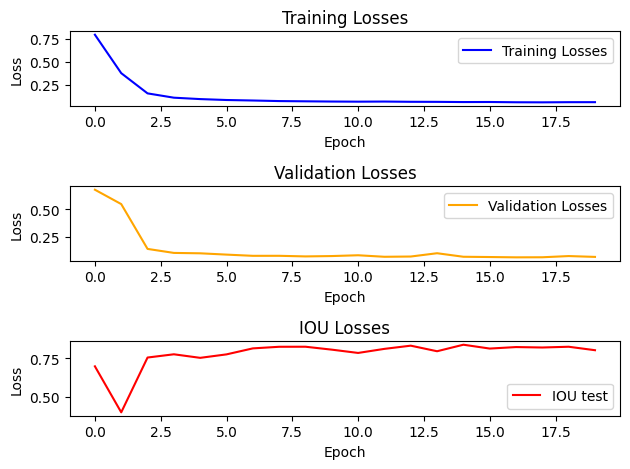

In [18]:
plt.subplot(3, 1, 1)
plt.plot(train_losses, label='Training Losses', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_losses, label='Validation Losses', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(iou_test, label='IOU test', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('IOU Losses')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation (оценка качества модели)

100%|██████████| 122/122 [01:02<00:00,  1.95it/s]


IOU: 0.8301586312050969
AP: -0.03889574523219029


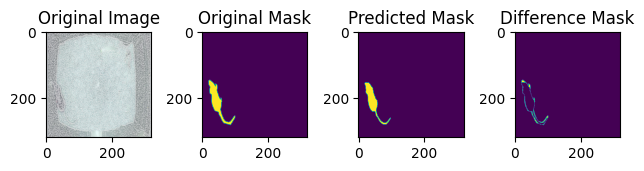

In [19]:
validation(model, train_loader, 1)

100%|██████████| 14/14 [00:07<00:00,  1.88it/s]


IOU: 0.8207151847436782
AP: -0.04071384565356749


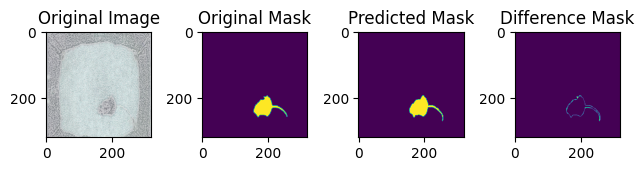

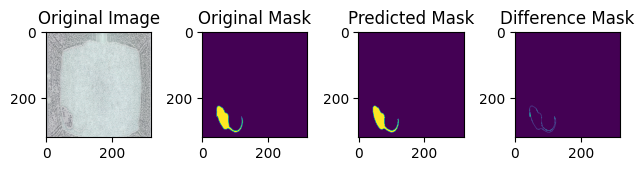

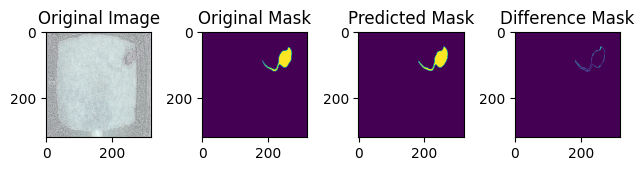

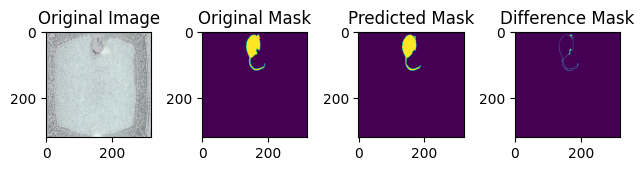

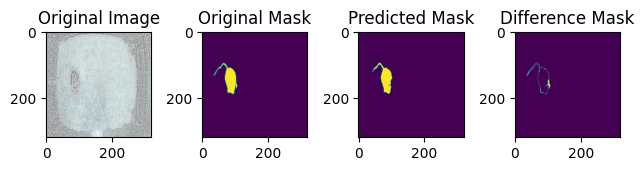

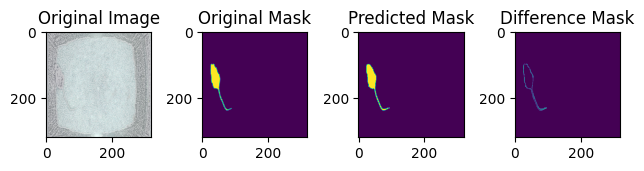

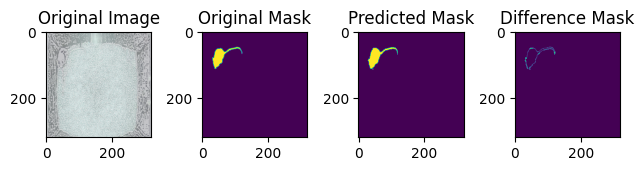

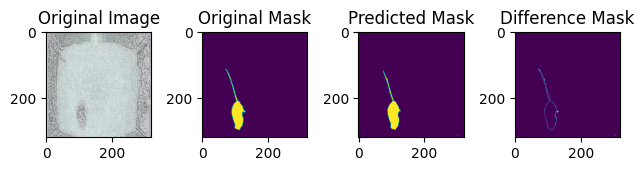

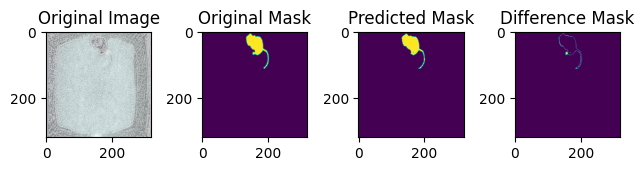

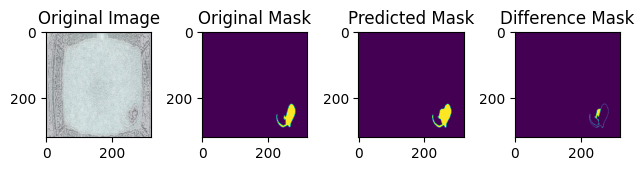

In [20]:
validation(model, val_loader, 10)

100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


IOU: 0.8020656542746758
AP: -0.05366010948976252


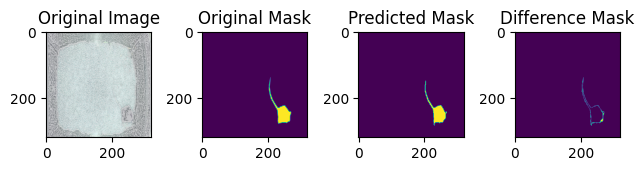

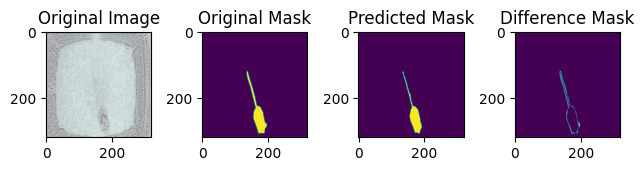

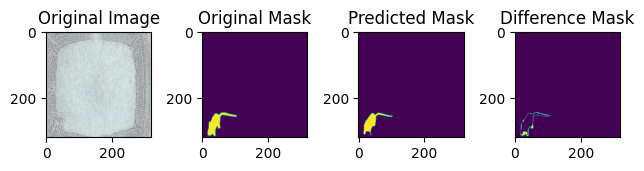

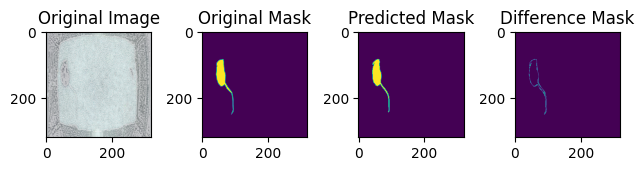

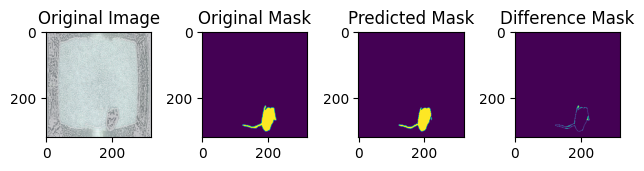

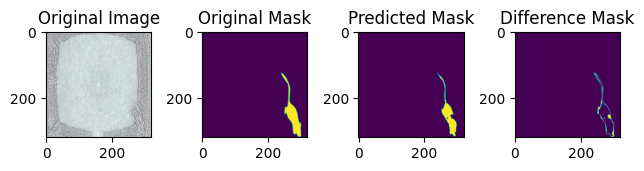

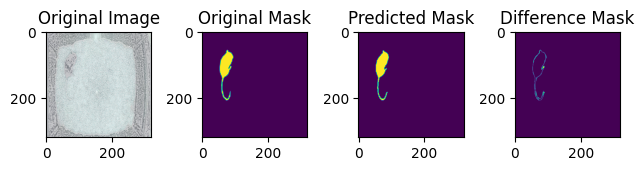

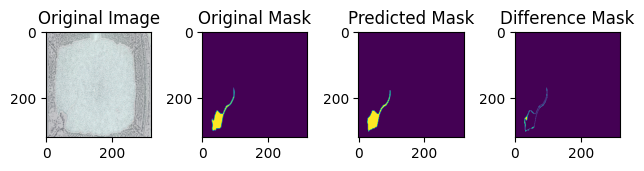

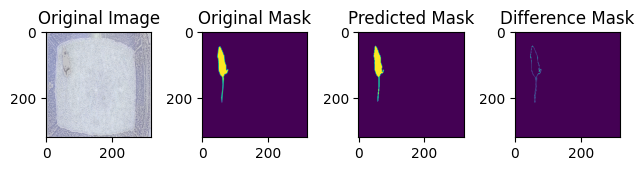

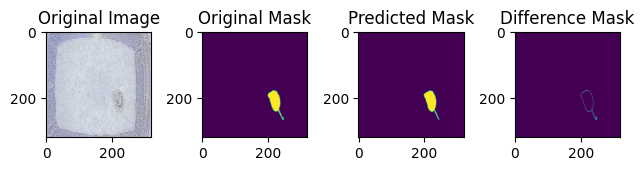

In [23]:
validation(model, test_loader, 10)

In [22]:
delete_generated_images(data_vertical, data_horizontal)

NameError: name 'delete_generated_images' is not defined